**The notebook below outlines how to take an initial path (vector line) and have it navigate possible obstacles**
- Say you're on vacation and are lounging on the beach
- As you've been out there longer than planned, your cooler's running empty just before the fireworks are about to start
- No worries, you have a drone and some friends back at the house
- Apply the script below to plan a safe flight path circumventing the high rises, construction areas and firework restricted area

In [91]:
m

In [56]:
import geopandas as gpd
from osgeo import gdal,ogr
import numpy
from shapely.geometry import Point, LineString
import rasterio
import sys
import subprocess
import warnings
import folium

# hide depreciation warnings for now
warnings.filterwarnings('ignore')


In [47]:
def import_data(file):
    file_in = gpd.read_file(file)
    print(f"imported: {file}")
    # ensure you capture any necessary projection changes
    file_in = check_projection(file_in)
    file_in.plot()
    return file_in

# check to ensure the geodatabase has a valid projection
# reproject to 4326 if needed (to match up with h3) 
def check_projection(file_in):
    if file_in.crs != 4326:
        print(f'  need to reproject, current crs: {file_in.crs}')
        file_in = file_in.to_crs(4326)
        print(f'  new crs: {file_in.crs}')
    return file_in

# if no intersection bypass the rest of the application and approve path or check against other elements
def check_path_intersection(flight_path, hazard):
    apply_method = flight_path.geometry.apply(lambda g: hazard.intersects(g))
    print(f'the apply method returns: \n{"-"*25}\n{apply_method}')
    any_true = apply_method.any(axis=1)
    if any_true.iloc[0] == True:
        print(f'\nRequested flight path impacted by restrictions, will need to create alternate path')
    else:
        print('flight plan looks good pending changes')
    # can alternatively use gpd.sjoin
    # sjoin_method = gpd.sjoin(flight_path, hazard, predicate='intersects')

# create a buffer of 400m around bounding box of requested path, sets base for raster layers
def flight_footprint(flight_path):
    buffer_400m = flight_path.to_crs(3857).buffer(400)
    bbox3857 = buffer_400m.bounds
    flight_bbox = buffer_400m.to_crs(4326).bounds
    return flight_bbox, bbox3857

# use gdal to rasterize any vector layers needed later on for analysis in GRASS
def gdal_rasterize(file_name, layer_name, temprast, raster_name, dfname):
    # layer to be rasterized
    dfname.to_crs(3857).to_file(file_name, layer=layer_name, driver='GPKG')
    vector_layer = ogr.Open(file_name)
    lyr = vector_layer.GetLayer(layer_name)
    # template raster to inherit settings from
    raster_template = gdal.Open(temprast)
    geot = raster_template.GetGeoTransform()
    rast_out = raster_name
    gdaldriver = gdal.GetDriverByName("GTiff")
    create_rasterout = gdaldriver.Create(rast_out, 
            raster_template.RasterXSize, 
            raster_template.RasterYSize, 
            1, 
            gdal.GDT_Float32)
    create_rasterout.SetGeoTransform(geot)
    gdal.RasterizeLayer(create_rasterout, [1], lyr)
    create_rasterout.GetRasterBand(1).SetNoDataValue(-99999)
    create_rasterout = None

def rasterio_save_raster(rastername, rastarray, bbox3857, height, width):
    # Set transform
    # west, south, east, north, width, height
    # bbox3857['minx'].iloc[0], bbox3857['miny'].iloc[0], bbox3857['maxx'].iloc[0], bbox3857['maxy'].iloc[0]
    transform=rasterio.transform.from_bounds(
            bbox3857['minx'].iloc[0], 
            bbox3857['miny'].iloc[0], 
            bbox3857['maxx'].iloc[0], 
            bbox3857['maxy'].iloc[0], 
            width=width, 
            height=height) 
    #proj4
    crs3857 = '+proj=merc +a=6378137 +b=6378137 +lat_ts=0 +lon_0=0 +x_0=0 +y_0=0 +k=1 +units=m +nadgrids=@null +wktext +no_defs +type=crs'
    # Save raster
    with rasterio.open(
            rastername,
            mode="w",
            driver="GTiff",
            height=rastarray.shape[0],
            width=rastarray.shape[1],
            count=1,
            dtype=rastarray.dtype,
            crs=crs3857,
            transform=transform,
    ) as new_dataset:
            new_dataset.write(rastarray, 1)


**Set constants based on computer settings**
- read from ignore file

In [57]:
import ignored_files

BASEPATH = ignored(basepath)
GRASSPATH = ignored(grasspath)

**Import requested flight path**
- Also import user input for hazards until api is set up

imported: ../data/samplePath.gpkg
  need to reproject, current crs: epsg:32618
  new crs: epsg:4326
imported: ../data/sampleHazard.geojson


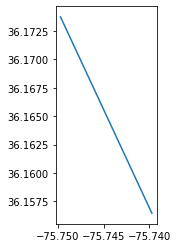

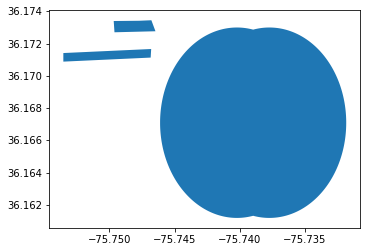

In [32]:
flight_path = import_data('../data/samplePath.gpkg')
hazard = import_data('../data/sampleHazard.geojson')

In [48]:
check_path_intersection(flight_path, hazard)

the apply method returns: 
-------------------------
      0     1      2     3
0  True  True  False  True

Requested flight path impacted by restrictions, will need to create alternate path


**Set up the project footprint and get basic dimensions**

In [49]:
footprint, bbox3857 = flight_footprint(flight_path)

# retrieve the upper left coordinate
origin_pt = gpd.GeoSeries(
    [
        Point(bbox3857['minx'].iloc[0], bbox3857['maxy'].iloc[0]),
    ],
)
# retrieve the upper right and bottom left coordinates
find_xy = gpd.GeoSeries(
    [
        Point(bbox3857['minx'].iloc[0], bbox3857['miny'].iloc[0]),
        Point(bbox3857['maxx'].iloc[0], bbox3857['maxy'].iloc[0]),
    ],
    index=range(1, 3),
)

# use the point coordinates collected above to calculate the height and width of the project footprint
bbdim = origin_pt.apply(lambda d: find_xy.distance(d))
bbdim = bbdim.round(0).astype(int)
height, width = int(bbdim[1].iloc[0]), int(bbdim[2].iloc[0])
print(f'The project footprint is {height} meters tall and {width} meters wide')

# grab the start and end coordinates of the requested flight path line
endsgeom = flight_path.to_crs(3857).loc[0, 'geometry']
startingpoint, destinationpoint = list(endsgeom[0].coords)[0], list(endsgeom[0].coords)[1]
print(f'Departing coordinates: {startingpoint}\nDestination coordinates: {destinationpoint}')

The project footprint is 3199 meters tall and 1916 meters wide
Departing coordinates: (-8432421.380708197, 4324562.31669551)
Destination coordinates: (-8431304.190914223, 4322162.52176221)


In [9]:
# create blank raster for the footprint - not entirely necessary
dst_fname = '../data/footprint-3857.tif'
raster = numpy.zeros((height, width), dtype=numpy.uint8)

rasterio_save_raster(dst_fname, raster, bbox3857, height, width)

**Create raster files of the vector layers**
- flight path: used to create the proximity cost
- hazards: needed in order to prevent passage though restricted areas

In [50]:
temprast = dst_fname

file_name = '../data/fp.gpkg'
layer_name = 'flightpath'
raster_name = '../data/flightpath_rast_nonulls.tif'
dfname = flight_path
gdal_rasterize(file_name, layer_name, temprast, raster_name, dfname)

file_name = '../data/hazard.gpkg'
layer_name = 'hazard'
raster_name = '../data/hazard_rast_nonulls.tif'
dfname = hazard

gdal_rasterize(file_name, layer_name, temprast, raster_name, dfname)



**Develop a proxiimty cost raster to ideally keep the path relative to initial request**

In [53]:
# open template raster to inherit settings
raster_name = '../data/flightpath_rast_nonulls.tif'
temprast = gdal.Open(raster_name, 0)
band = temprast.GetRasterBand(1)
transform = temprast.GetGeoTransform()
tempproj = temprast.GetProjection()

# create empty proximity raster
raster_name = '../data/path_proximity_nonulls.tif'
driver = gdal.GetDriverByName('GTiff')
raster_out = driver.Create(raster_name, width, height, 1, gdal.GDT_Float32)
raster_out.SetGeoTransform(transform)
raster_out.SetProjection(tempproj)
out_band = raster_out.GetRasterBand(1)

# compute proximity
gdal.ComputeProximity(band, out_band, ['VALUES=255', 'DISTUNITS=PIXEL'])

# delete input and output rasters
del raster_name, raster_out

**Don't want to risk the path cheating and cutting through restricted areas so set the hazard cost high**

In [54]:
haz_rast = '../data/hazard_rast_nonulls.tif'
with rasterio.open(haz_rast) as src:
    haz_band1 = src.read(1)

# alt method
# b = numpy.where(haz_band1 > 0, 1000000, 0) 
haz_band1[haz_band1 > 0] = 1000000

# create the raster
raster_name = "../data/newhazard_rast.tif"
rasterio_save_raster(raster_name, haz_band1, bbox3857, height, width)

**Create the final cost raster by adding up the impediments**
- proximity to originally requested route
- hazards/no-fly zones

In [55]:
prox_rast = '../data/path_proximity_nonulls.tif'
with rasterio.open(prox_rast) as src:
    prox = src.read(1)
    

haz_rast = '../data/newhazard_rast.tif'
with rasterio.open(haz_rast) as src:
    haz = src.read(1)

newcost = prox + haz

raster_name = "../data/initial_cost.tif"
rasterio_save_raster(raster_name, newcost, bbox3857, height, width)

**Access GRASS for the Least Cost Path Analysis**
- Tried getting an A* up and running, but it would always end up cheating and cutting through restricted areas

In [60]:
# initiate local settings for the GRASS env
grass8bin = f"{GRASSPATH}grass82.bat"
gisdb = f"{BASEPATH}data\ignorethese\grassdata"
location = "drone_flight"
mapset = "PERMANENT"

# query GRASS GIS itself for its Python package path
grass_cmd = [grass8bin, "--config", "python_path"]
process = subprocess.run(grass_cmd, check=True, text=True, stdout=subprocess.PIPE)

# define GRASS-Python environment
sys.path.append(process.stdout.strip())

# import (some) GRASS Python bindings
import grass.script as gs
import grass.script.setup as gsetup

# launch session
rcfile = gsetup.init(gisdb, location, mapset)


filein = f"{BASEPATH}data\\samplePath.gpkg"
costin = f"{BASEPATH}data/initial_cost.tif"
lcp_vector = f"{BASEPATH}data/grass_leastcostpath_line.gpkg"

# bring in the initial cost raster
gs.run_command("r.in.gdal", input=costin, output='initial_cost', overwrite=True)
# use the initial cost raster footprint to set the region window, GRASS doesn't like it when it's set in the wrong spot
gs.run_command("g.region", raster='initial_cost@PERMANENT')
# clear out layers from previous runs
gs.run_command("g.remove", type='all', pattern='py_*', flags='f')
# different from earlier cost raster - this one is directional from start to destination
gs.run_command("r.cost", input='initial_cost@PERMANENT', output='py_cost', nearest='py_nsp', outdir='py_mvmt', start_coordinates=startingpoint, stop_coordinates=destinationpoint, memory='300')
# drains from high to low calculated in the previous step - therefore the starting point here is actually the destination 
gs.run_command("r.drain", input='py_cost@PERMANENT', direction='py_mvmt@PERMANENT', output='py_drainoutput', drain='py_drain', start_coordinates=destinationpoint, overwrite=True)
# export the new vector path that circumvents any hazards
gs.run_command("v.out.ogr", input='py_drain', output=lcp_vector, overwrite=True)

current_env = gs.gisenv()

print(f'Layers in this GRASS location ({current_env["LOCATION_NAME"]}):')
for t in ('raster','vector'):
    print(f"\n{t}:")
    print('-'*(len(f"{t}:")-1))
    gs.message(f"\nAvailable {t} maps:")
    for lyr in gs.list_strings(type=t):
        print(lyr)

# clean up the session
gsetup.finish()

Layers in this GRASS location (drone_flight):

raster:
------
initial_cost@PERMANENT
py_cost@PERMANENT
py_drainoutput@PERMANENT
py_mvmt@PERMANENT
py_nsp@PERMANENT

vector:
------
py_drain@PERMANENT


**Simplify the linestring removing excess nodes so it's a more direct flight path**
- needs to be optimized yet

In [61]:
haznbuf = hazard.to_crs(3857).buffer(-1)
src_path = '../data/neghazard.gpkg'
lyr_name = 'smaller'
haznbuf.to_crs(3857).to_file(src_path, layer=lyr_name, driver='GPKG')
hazbuf = gpd.read_file('../data/neghazard.gpkg')

lcpout = gpd.read_file('E:/CMapS/portfolio_projects/droneFlight/src/data/grass_leastcostpath_line.gpkg')
geom = lcpout.loc[0, 'geometry']

newcoords = list()
for i, p in enumerate(geom.coords):
    tmplist = list(geom.coords)
    if i == 0:
        newcoords.append(tmplist[0])
        line_sp = newcoords[-1]
    elif i > 0 and i < len(list(geom.coords))-1:
        newline = gpd.GeoDataFrame(index=[0], crs='epsg:3857', geometry=[LineString([line_sp, p])])
        sjoin_method = gpd.sjoin(newline, hazbuf, predicate='crosses')
        if sjoin_method.shape[0] > 0:
            newcoords.append(tmplist[i-1])
            newcoords.append(p)
            # line_sp = (p)
            # newcoords.append(tmplist[i-1])
            line_sp = p
    else:
        newcoords.append(tmplist[-1])

nfp = gpd.GeoDataFrame(index=[0], crs='epsg:3857', geometry=[LineString(newcoords)])
src_path = '../data/approved_flight_path.gpkg'
lyr_name = 'approved_flight_path'
nfp.to_crs(3857).to_file(src_path, layer=lyr_name, driver='GPKG')


In [90]:
m = hazard.explore(
    min_lat=25,min_lon=-125,max_lat=50,max_lon=-66.5,
    max_bounds=True,
    zoom_start=14,
    # tiles = 'cartodbpositron',
    name = 'Hazards',
    style_kwds = dict(color="orange", #stroke color
                      weight='0.1', #stoke width
                         ),
    )
m = flight_path.explore(
    m=m, 
    name='Initially Requested Path',
    style_kwds = dict(color='#CB0000',
                      weight = '3')
    )
m = lcpout.explore(
    m=m, 
    name='Suggested GRASS Route',
    style_kwds = dict(color='#36E200',
                      weight = '3')
    )
m = nfp.explore(
    m=m,
    name='Approved Flight Path',
    style_kwds = dict(color="#0020FF", #stroke color
                      weight='3', #stoke width
                         ),
    )

folium.raster_layers.TileLayer(tiles='cartodbpositron', name='cartodbpositron').add_to(m)
folium.LayerControl(collapsed=False).add_to(m)

m

**To Do**
- Incorporate the weather API
- Accept user input
- Track down FAA notificaitons/restrictions